# Neural Machine Translation

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\PEIM001\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


## Dataset

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 25484.49it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Neural machine translation with attention

In [6]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [7]:
def one_step_attention(a, s_prev):
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e
    e = densor1(concat)
    
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies
    energies = densor2(e)
    
    # Use "activator" on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
        
    return context

In [8]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [9]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
      
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state]
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s,c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

In [10]:
# Create model
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [11]:
# Model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_1[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_1[0][0]            
          

In [12]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
# Define inputs
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [14]:
# Fit model
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1


 2800/10000 [=======>......................] - ETA: 14:31 - loss: 24.0342 - dense_3_loss: 2.3957 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.1400 - dense_3_acc_3: 0.1000 - dense_3_acc_4: 0.0000e+00 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0900 - dense_3_acc_7: 0.0000e+00 - dense_3_acc_8: 0.0000e+00 - dense_3_acc_9: 0.10 - ETA: 7:14 - loss: 23.8318 - dense_3_loss: 2.4042 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.0700 - dense_3_acc_3: 0.0500 - dense_3_acc_4: 0.5000 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0450 - dense_3_acc_7: 0.5000 - dense_3_acc_8: 0.0000e+00 - dense_3_acc_9: 0.0500         - ETA: 4:49 - loss: 23.6346 - dense_3_loss: 2.4215 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.0467 - dense_3_acc_3: 0.0333 - dense_3_acc_4: 0.6667 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0300 - dense_3_acc_7: 0.6667 - dense_3_acc_8: 0.0000e+00 - dense_3_acc_9: 0.033 - ETA: 3:37 - loss: 23.383

 5700/10000 [================>.............] - ETA: 27s - loss: 21.3792 - dense_3_loss: 2.7684 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.3124 - dense_3_acc_2: 0.1252 - dense_3_acc_3: 0.0531 - dense_3_acc_4: 0.6424 - dense_3_acc_5: 0.1797 - dense_3_acc_6: 0.0155 - dense_3_acc_7: 0.8024 - dense_3_acc_8: 0.0428 - dense_3_acc_9: 0.03 - ETA: 26s - loss: 21.3245 - dense_3_loss: 2.7677 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.3247 - dense_3_acc_2: 0.1297 - dense_3_acc_3: 0.0543 - dense_3_acc_4: 0.6543 - dense_3_acc_5: 0.1737 - dense_3_acc_6: 0.0150 - dense_3_acc_7: 0.8090 - dense_3_acc_8: 0.0413 - dense_3_acc_9: 0.02 - ETA: 24s - loss: 21.2822 - dense_3_loss: 2.7663 - dense_3_acc: 0.0000e+00 - dense_3_acc_1: 0.3332 - dense_3_acc_2: 0.1303 - dense_3_acc_3: 0.0565 - dense_3_acc_4: 0.6655 - dense_3_acc_5: 0.1681 - dense_3_acc_6: 0.0145 - dense_3_acc_7: 0.8152 - dense_3_acc_8: 0.0400 - dense_3_acc_9: 0.02 - ETA: 23s - loss: 21.2293 - dense_3_loss: 2.7640 - dense_3_acc: 0.0000e+00 - dense_3

 8600/10000 [========================>.....] - ETA: 9s - loss: 20.0264 - dense_3_loss: 2.7482 - dense_3_acc: 0.1781 - dense_3_acc_1: 0.4750 - dense_3_acc_2: 0.1772 - dense_3_acc_3: 0.0584 - dense_3_acc_4: 0.8212 - dense_3_acc_5: 0.0900 - dense_3_acc_6: 0.0086 - dense_3_acc_7: 0.8833 - dense_3_acc_8: 0.0997 - dense_3_acc_9: 0.064 - ETA: 9s - loss: 19.9726 - dense_3_loss: 2.7446 - dense_3_acc: 0.1844 - dense_3_acc_1: 0.4763 - dense_3_acc_2: 0.1778 - dense_3_acc_3: 0.0581 - dense_3_acc_4: 0.8242 - dense_3_acc_5: 0.0893 - dense_3_acc_6: 0.0090 - dense_3_acc_7: 0.8839 - dense_3_acc_8: 0.1032 - dense_3_acc_9: 0.065 - ETA: 8s - loss: 19.9162 - dense_3_loss: 2.7415 - dense_3_acc: 0.1900 - dense_3_acc_1: 0.4770 - dense_3_acc_2: 0.1782 - dense_3_acc_3: 0.0580 - dense_3_acc_4: 0.8272 - dense_3_acc_5: 0.0878 - dense_3_acc_6: 0.0090 - dense_3_acc_7: 0.8858 - dense_3_acc_8: 0.1027 - dense_3_acc_9: 0.067 - ETA: 8s - loss: 19.8532 - dense_3_loss: 2.7369 - dense_3_acc: 0.1966 - dense_3_acc_1: 0.4789 - 

10000/10000 [==============================] - ETA: 2s - loss: 17.9622 - dense_3_loss: 2.6256 - dense_3_acc: 0.3177 - dense_3_acc_1: 0.5313 - dense_3_acc_2: 0.2301 - dense_3_acc_3: 0.0639 - dense_3_acc_4: 0.8808 - dense_3_acc_5: 0.3164 - dense_3_acc_6: 0.0354 - dense_3_acc_7: 0.9211 - dense_3_acc_8: 0.1913 - dense_3_acc_9: 0.084 - ETA: 2s - loss: 17.8907 - dense_3_loss: 2.6213 - dense_3_acc: 0.3215 - dense_3_acc_1: 0.5345 - dense_3_acc_2: 0.2307 - dense_3_acc_3: 0.0653 - dense_3_acc_4: 0.8822 - dense_3_acc_5: 0.3226 - dense_3_acc_6: 0.0366 - dense_3_acc_7: 0.9220 - dense_3_acc_8: 0.1930 - dense_3_acc_9: 0.085 - ETA: 1s - loss: 17.8199 - dense_3_loss: 2.6174 - dense_3_acc: 0.3247 - dense_3_acc_1: 0.5375 - dense_3_acc_2: 0.2317 - dense_3_acc_3: 0.0658 - dense_3_acc_4: 0.8835 - dense_3_acc_5: 0.3288 - dense_3_acc_6: 0.0385 - dense_3_acc_7: 0.9229 - dense_3_acc_8: 0.1949 - dense_3_acc_9: 0.086 - ETA: 1s - loss: 17.7526 - dense_3_loss: 2.6134 - dense_3_acc: 0.3280 - dense_3_acc_1: 0.5401 - 

In [44]:
# Load model that was trained longer
model.load_weights('models/model.h5')

In [45]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))[np.newaxis,...]
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))


source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


<Figure size 432x288 with 0 Axes>

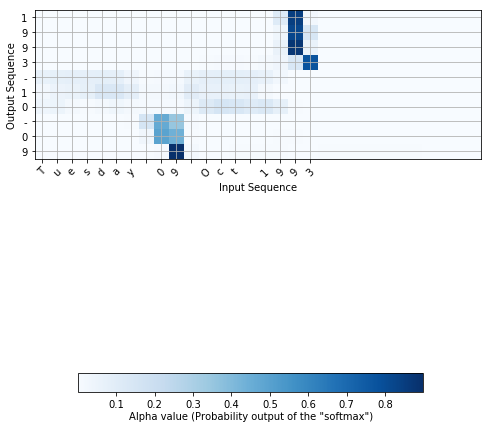

In [46]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)